<a href="https://colab.research.google.com/github/ankile/Adversarial-Diffusion/blob/main/src/Train_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Denoising Diffusion Probabilistic Model on the PCam dataset

> This code is based on an example notebook created by Hugging Face and the `diffusers` package team

The following two cells must be run before the runtime is restarted to make sure the packages are resolved correctly because of the `tiatoolbox` package.

In [2]:
%%capture
!pip install diffusers[training]==0.5.1
!pip install "ipywidgets>=7,<8"
!pip install tiatoolbox

In [3]:
%%capture
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools

As google colab has disabled external widgets, we need to enable it explicitly. Run the following cell to be able to use `notebook_login` and `tqdm`:

In [1]:
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful



Then you need to install Git-LFS to upload your model checkpoints:

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

## Config

For convenience, we define a configuration grouping all the training hyperparameters. This would be similar to the arguments used for a [training script](https://github.com/huggingface/diffusers/tree/main/examples).
Here we choose reasonable defaults for hyperparameters like `num_epochs`, `learning_rate`, `lr_warmup_steps`, but feel free to adjust them if you train on your own dataset. For example, `num_epochs` can be increased to 100 for better visual quality.

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 96  # the generated image resolution
    train_batch_size = 48
    eval_batch_size = 48  # how many images to sample during evaluation
    num_epochs = 20
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 5
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-pcam-96-flip'  # the model namy locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

## Loading the dataset


In [5]:
import torchvision

from tiatoolbox.models.dataset.classification import predefined_preproc_func

# This makes sure that the preprocessing is equal to the pretrained model
preprocess = preprocess_pcam = predefined_preproc_func("pcam").func
preprocess.transforms.insert(0, torchvision.transforms.RandomHorizontalFlip(p=0.2))

In [6]:
config.dataset_name = "pcam-96"

dataset = torchvision.datasets.PCAM(
    root="./",
    split="val",
    download=True,
    transform=preprocess,
)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Inspect some examples

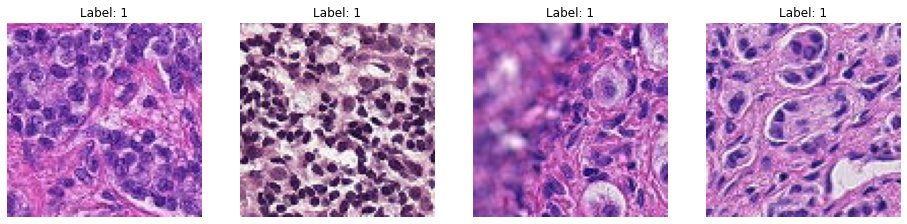

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, (image, label) in enumerate(dataset):

    axs[i].imshow(image.permute(1, 2, 0).numpy())
    axs[i].set_axis_off()
    axs[i].set_title(f"Label: {label}")


    if i >= 3: break
fig.show()

Now that all our images have the same size and are converted to tensors, we can create the dataloader we will use for training.

In [8]:
import torch

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=config.train_batch_size,
    shuffle=True,
)

## Defining the diffusion model

Here we set up our diffusion model. Diffusion models are neural networks that are trained to predict slightly less noisy images from a noisy input. At inference, they can be used to iteratively transform a random noise to generate an image:

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Don't worry too much about the math if you're not familiar with it, the import part to remember is that our model corresponds to the arrow $p_{\theta}(x_{t-1}|x_{t})$ (which is a fancy way of saying: predict a slightly less noisy image).

The interesting part is that it's really easy to add some noise to an image, so the training can happen in a semi-supervised fashion as follows:
1. Take an image from the training set.
2. Apply to it some random noise $t$ times (this will give the $x_{t-1}$ and the $x_{t}$ in the figure above).
3. Give this noisy image to the model along with the value of $t$.
4. Compute a loss from the output of the model and the noised image $x_{t-1}$.

Then we can apply gradient descent and repeat this process multiple times.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downample path to the corresponsding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size. 
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):


In [9]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

## Defining the noise scheduler

We're using the original, linear schedule.

In [12]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Example image with noise from the scheduler

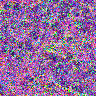

In [13]:
import torch
from PIL import Image

sample_image = dataset[0][0].unsqueeze(0)

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray((noisy_image.permute(0, 2, 3, 1) * 255).type(torch.uint8).numpy()[0])

## Setting up training

We have all we need to be able to train our model! Let's use a standard AdamW optimizer:

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

 And a cosine learning rate schedule:

In [16]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

To evaluate our model, we use the `DDPMPipeline` which is an easy way to perform end-to-end inference (see this notebook [TODO link] for more detail). We will use this pipeline to generate a batch of sample images and save it as a grid to the disk. 

In [17]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

## The training loop

In [18]:
from accelerate import Accelerator
from diffusers.hub_utils import init_git_repo, push_to_hub
from datetime import datetime

from tqdm.auto import tqdm
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo = init_git_repo(config, at_init=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0
    starttime = datetime.now()
    total_batches = len(train_dataloader) * config.num_epochs

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            global_step += 1

            progress_bar.update(1)
            elapsed = datetime.now() - starttime
            total = elapsed * total_batches / global_step

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    push_to_hub(config, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir) 

## Let's train!


In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=-1)

Launching training on one GPU.


  warnings.warn(

Cloning https://huggingface.co/ankile/ddpm-pcam-96-flip into local empty directory.


  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0004.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.30k/434M [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1670854773.a22bee3454e3.503.0:   1%|          | 3.30k/423k …

Upload file samples/0004.png:   1%|          | 3.30k/335k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/ankile/ddpm-pcam-96-flip
   8028b81..0ac2464  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/ankile/ddpm-pcam-96-flip
   8028b81..0ac2464  main -> main

To https://huggingface.co/ankile/ddpm-pcam-96-flip
   0ac2464..97eef3f  main -> main

   0ac2464..97eef3f  main -> main



  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0009.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.30k/434M [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1670854773.a22bee3454e3.503.0:   0%|          | 3.30k/847k …

Upload file samples/0009.png:   1%|1         | 3.30k/265k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/ankile/ddpm-pcam-96-flip
   97eef3f..2c4e119  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/ankile/ddpm-pcam-96-flip
   97eef3f..2c4e119  main -> main



  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/683 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Adding files tracked by Git LFS: ['samples/0014.png']. This may take a bit of time if the files are large.


Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.30k/434M [00:00<?, ?B/s]

Upload file samples/0014.png:   1%|1         | 3.30k/299k [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1670854773.a22bee3454e3.503.0:   0%|          | 3.30k/1.24M…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/ankile/ddpm-pcam-96-flip
   2c4e119..97dd208  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/ankile/ddpm-pcam-96-flip
   2c4e119..97dd208  main -> main



  0%|          | 0/683 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Let's have a look at the final image grid produced by the trained diffusion model:

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

# Noise and Denoise an Image!

In [19]:
# Get the model
from diffusers import DiffusionPipeline

trained_model = DiffusionPipeline.from_pretrained("ankile/ddpm-pcam-96-flip").unet.to("cuda")

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/785 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455M [00:00<?, ?B/s]

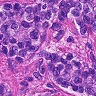

In [20]:
# Look at clean image
def show(tensor):
    return Image.fromarray((tensor.permute(0, 2, 3, 1) * 255.0).type(torch.uint8).numpy()[0])

show(sample_image)

In [34]:
device = 'cuda'

In [35]:
# Add noise
noise_level = 50

def noise(img, t):
    noise = torch.randn(img.shape).to(device)
    timesteps = torch.LongTensor([t]).to(device)
    noisy_image = noise_scheduler.add_noise(img, noise, timesteps)
    return noisy_image


noisy_image = noise(sample_image, noise_level)
show(noisy_image)

RuntimeError: ignored

In [40]:
# Denoise
@torch.no_grad()
def denoise(img, ts, progress=True):
    noise_scheduler.set_timesteps(1_000)
    img_reconstruct = img.reshape(1, 3, config.image_size, config.image_size).to("cuda")

    for t in tqdm(noise_scheduler.timesteps[-ts:], disable=not progress):
        # 1. predict noise model_output
        model_output = trained_model(img_reconstruct, t).sample

        # 2. compute previous img_reconstruct: x_t -> x_t-1
        img_reconstruct = noise_scheduler.step(model_output, t, img_reconstruct).prev_sample

    return img_reconstruct


img_reconstruct = denoise(noisy_image, noise_level)

  0%|          | 0/50 [00:00<?, ?it/s]

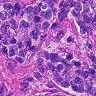

In [24]:
reconstructed = img_reconstruct.detach().cpu()
show(reconstructed)

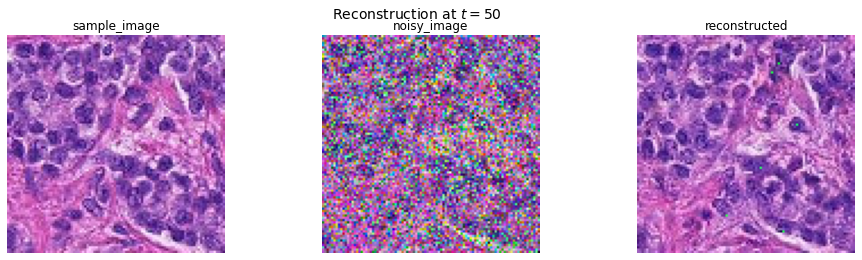

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

images = dict(
    sample_image=sample_image,
    noisy_image=noisy_image,
    reconstructed=reconstructed,
)

for i, (title, image) in enumerate(images.items()):
    axs[i].imshow(show(image))
    axs[i].set_axis_off()
    axs[i].set_title(title)
fig.suptitle(f"Reconstruction at $t=${noise_level}", fontsize=14);

### Create batches of 100 denoised images

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
basepath = "/content/drive/MyDrive/# 1. Semester/6.7900/ML Final Project Fall 22/adverserial_examples"

In [44]:
examples = torch.load(basepath + "/tensors.pt")

for t in [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 200, 300, 400]:
    purifieds = []
    for img, label in tqdm(examples, desc=f"t={t}"):
        noisy = noise(img, t)
        denoised = denoise(noisy, t, progress=False)

        purifieds.append((denoised, label))

    with open(basepath + f"/purified_100_t_{t}.pt", "wb") as f:
        torch.save(purifieds, f)

t=200:   0%|          | 0/100 [00:00<?, ?it/s]

t=300:   0%|          | 0/100 [00:00<?, ?it/s]

t=400:   0%|          | 0/100 [00:00<?, ?it/s]